## Pose Optimization with Differentable Rendering

### Imports

In [1]:
from copy import deepcopy
# math
import numpy as np
# optim
import torch
# graphics
import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# plots
from matplotlib import pyplot as plt

# setup
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

Mitsuba 3 Variant: llvm_ad_rgb


### Scene

In [2]:
# camera positioned to view the scene, adjust as needed
cam_pos = np.array([0.0, 1.0, 5.0])  
cam_target = np.array([0.0, 1.0, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])

# particle
particle_init_pos = np.array([0.0, 1.0, 0.0])
particle_rgb = np.array([0.2, 0.25, 0.7])

# target
target_pos = np.array([-1.5, 2.5, 0.0])
target_trans = (target_pos - particle_init_pos)

# optimization radiuses to try
fail_radius = 1.0
success_radius = 1.5

### Rendering

In [3]:
img_width = 256
img_height = 256
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': success_radius,
        'bsdf': {'type': 'diffuse'}
    },
}


init_scene_dict = dict(scene_dict)
init_scene_dict['particle']['center'] = deepcopy(particle_init_pos)
img_init = mi.render(mi.load_dict(init_scene_dict), spp=16)

target_scene_dict = dict(scene_dict)
target_scene_dict['particle']['center'] = deepcopy(target_pos)
img_ref = mi.render(mi.load_dict(target_scene_dict), spp=16)

### Optimization

In [4]:
# training details
train_iters = 60
train_rate = 1.0
train_save_interval = 5

# rendering
scene_dict = dict(scene_dict)
scene_dict['particle']['center'] = deepcopy(particle_init_pos)
scene = mi.load_dict(scene_dict)
scene_spp = 4
params = mi.traverse(scene)
start_state = mi.Transform4f(params['particle.to_world'])
@dr.wrap_ad(source='torch', target='drjit')
def render(trans):
    trans = dr.unravel(mi.Point3f, trans)
    trafo = mi.Transform4f.translate([trans.x, trans.y, 0.0])
    params['particle.to_world'] = trafo @ start_state
    params.update()
    img = mi.render(scene, params, spp=scene_spp)
    return img

# variables
trans = torch.tensor([[0.0, 0.0, 0.0]], requires_grad=True)
target = torch.tensor(target_trans, dtype=torch.float32).unsqueeze(0)

# optimization
opt = torch.optim.SGD([trans], lr=train_rate)
loss = torch.nn.MSELoss(reduction='mean')

# metrics
trans_errors = []
img_losses = []

for i in range(train_iters+1):
    opt.zero_grad()

    # forward pass
    img = render(trans)
    img_loss = loss(img, img_ref.torch())
    if i < train_iters:
        # backprop
        img_loss.backward()
        opt.step()

    img_losses.append(img_loss.detach().numpy())
    trans_error = torch.linalg.norm(target - trans).detach().numpy()
    trans_errors.append(trans_error)
    if i % train_save_interval == 0:
        print(f"iter_{i:02d}: img_loss={img_losses[-1]:6f}, trans_error={trans_errors[-1]:6f} trans=[{trans[0,0]:.4f}, {trans[0,1]:.4f}]")

iter_00: img_loss=0.090350, trans_error=2.084294 trans=[-0.0264, 0.0260]
iter_05: img_loss=0.083176, trans_error=1.892153 trans=[-0.1607, 0.1634]
iter_10: img_loss=0.074914, trans_error=1.689179 trans=[-0.3070, 0.3041]
iter_15: img_loss=0.065813, trans_error=1.474889 trans=[-0.4599, 0.4543]
iter_20: img_loss=0.055588, trans_error=1.248817 trans=[-0.6207, 0.6133]
iter_25: img_loss=0.044374, trans_error=1.013006 trans=[-0.7889, 0.7785]
iter_30: img_loss=0.032511, trans_error=0.766933 trans=[-0.9610, 0.9544]
iter_35: img_loss=0.020120, trans_error=0.523273 trans=[-1.1311, 1.1289]
iter_40: img_loss=0.010416, trans_error=0.321993 trans=[-1.2703, 1.2744]
iter_45: img_loss=0.005223, trans_error=0.170817 trans=[-1.3769, 1.3815]
iter_50: img_loss=0.001574, trans_error=0.043915 trans=[-1.4690, 1.4689]
iter_55: img_loss=0.000356, trans_error=0.001153 trans=[-1.5011, 1.5001]
iter_60: img_loss=0.000356, trans_error=0.001308 trans=[-1.5013, 1.5002]


### Results

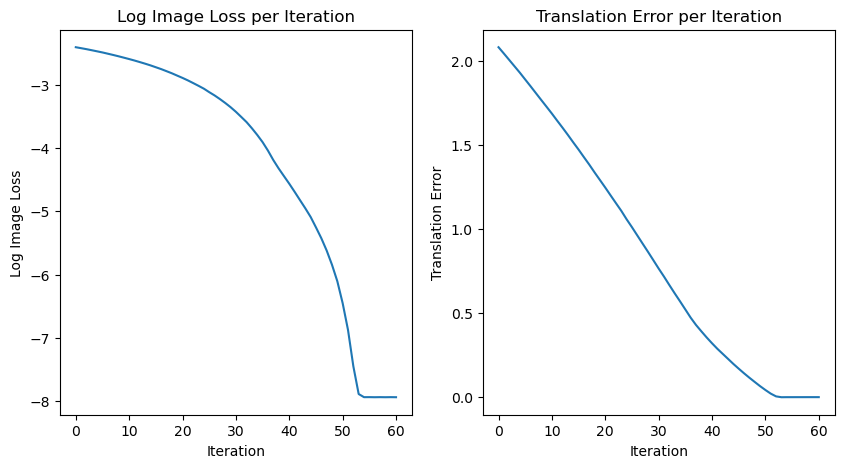

In [5]:
########
# Loss #
########
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(np.log(img_losses))
axs[0].set_xlabel('Iteration'); 
axs[0].set_ylabel('Log Image Loss'); 
axs[0].set_title('Log Image Loss per Iteration');

axs[1].plot(trans_errors)
axs[1].set_xlabel('Iteration');
axs[1].set_ylabel('Translation Error'); 
axs[1].set_title('Translation Error per Iteration');

plt.show()
#plt.savefig('fig_img_pose_optim.pdf', bbox_inches='tight')

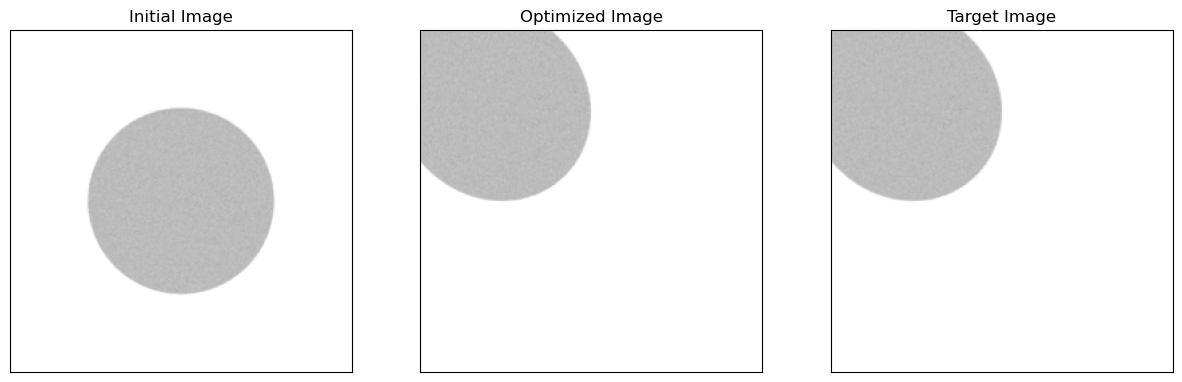

In [7]:
##########
# States #
##########
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(mi.util.convert_to_bitmap(img_init))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Initial Image')

axs[1].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=16)))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Optimized Image')

axs[2].imshow(mi.util.convert_to_bitmap(img_ref))
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Target Image')

plt.show()
#plt.savefig('fig_img_pose_states.pdf', bbox_inches='tight')